In [1]:
import caesar
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import tqdm
import pickle
import pandas as pd
import yt
import scipy
from scipy import interpolate

/blue/narayanan/a.ravishankar/py38/lib/python3.8/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/a.ravishankar/.config/yt/ytrc is deprecated in favor of /home/a.ravishankar/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [45]:
# Filepaths and parameters to adjust
MS_type = 'linear'

#csobj = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0226_z0.812.hdf5")
#csobj = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0210_z1.037.hdf5")
#csobj = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0197_z1.244.hdf5")
#csobj = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0169_z1.788.hdf5")
#csobj = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0160_z2.000.hdf5")
#csobj = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0150_z2.262.hdf5")
#csobj = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0139_z2.590.hdf5")
#csobj = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0127_z3.003.hdf5")
csobj = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0114_z3.534.hdf5")
#csobj = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0104_z4.015.hdf5")

t = float(csobj.simulation.time)*u.s
t = t.to(u.Gyr)
z = float(csobj.simulation.redshift)

### compute the main sequence for the snapshot
all_caesar_ids = [gal.GroupID for gal in csobj.galaxies]
mstar = np.array([gal.masses['stellar'] for gal in csobj.galaxies])
mgas = np.array([gal.masses['gas'] for gal in csobj.galaxies])
gas_radii = np.array([gal.radii['gas'].in_units("kpc") for gal in csobj.galaxies])
t_obs = float(t.value)

sfr = np.array([gal.sfr for gal in csobj.galaxies])
sSFR = sfr/mstar
sfr[sfr == 1e-2] = 1e-13*mstar[sfr==1e-2] 

bins = np.arange(np.min(np.log10(mstar)), np.max(np.log10(mstar))+0.5, 0.2)
bincenters = 0.5*(bins[1:]+bins[:-1])

t_obs = (t_obs*u.Gyr).to(u.yr).value

# iteratively fit polynomial to the MS
star_forming_galaxies = np.ones(shape=mstar.shape, dtype=bool)
for i in range(5):
    median, sigma = np.array([]), np.array([])
    for left_edge, right_edge in zip(bins[:-1], bins[1:]):
        left_edge, right_edge = np.round(left_edge, 1), np.round(right_edge,1)
        s = sfr[(np.log10(mstar) > left_edge)&(np.log10(mstar)<=right_edge)&(star_forming_galaxies)]
        s = np.log10(s)
        m = np.median(s)
        #print(m)
        sig = np.sqrt(np.sum((s-m)**2)/len(s)) # basically the std deviation but with median instead of mean
        median = np.append(median,m)
        sigma = np.append(sigma, sig)
    #print(median,m)
    
    if MS_type == 'linear': # if you want a linear MS for SIMBA
        #slope, yint, r, p, sig = scipy.stats.linregress(bincenters[(bincenters < 11)], median[(bincenters < 11)]) # is 11.2 a good number? check later
        slope, yint, r, p, sig = scipy.stats.linregress(bincenters[((bincenters < 11) & (~np.isnan(median)))], median[((bincenters < 11) & (~np.isnan(median)))]) # is 11.2 a good number? check later
        ms_sfr = 10**(slope*np.log10(mstar)+yint)
        print(median,slope,yint,r,p,sig)
    elif MS_type == 'bending': # if you want a bending MS for SIMBA
        p = np.polyfit(bincenters[~np.isnan(median)], median[~np.isnan(median)], 2)
        ms_sfr = 10**(np.log10(mstar)**2 * p[0] + np.log10(mstar)*p[1] + p[2])
    else: raise Exception('Unrecognized MS_type')
    
    star_forming_galaxies = (np.log10(sfr/ms_sfr) > -0.5)
    print(star_forming_galaxies)
    #star_forming_galaxies = (np.abs(np.log10(sfr/ms_sfr))<0.5) 
    #for i in range(0,len(star_forming_galaxies)):
        
    #    star_forming_galaxies[i] = (np.log10(mstar[i])>9 and (np.log10(sfr[i]/ms_sfr[i]))>-0.5)
    
selected_ids = []
mod_mstar = []
mod_sfr = []
    
for i in range(0,len(star_forming_galaxies)):
        
    if star_forming_galaxies[i]==True:
        if sfr[i]!=1 and mgas[i]>=1e8 and mstar[i]>=1e9 and gas_radii[i]<=1000 and gas_radii[i]>=5:
            selected_ids.append(all_caesar_ids[i])
            mod_mstar.append(mstar[i])
            mod_sfr.append(sfr[i])
    #star_forming_galaxies = (np.log10(sfr/ms_sfr) > -0.5)
mod_mstar = np.array(mod_mstar)
mod_sfr = np.array(mod_sfr)

yt : [INFO     ] 2023-06-02 05:36:52,072 Opening /orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0114_z3.534.hdf5
yt : [INFO     ] 2023-06-02 05:36:52,213 Found 97745 halos
yt : [INFO     ] 2023-06-02 05:36:52,334 Found 1894 galaxies
yt : [INFO     ] 2023-06-02 05:36:52,472 Found 26612 clouds


[-1.44409702 -1.23215832 -1.06249677 -0.80376263 -0.50204749 -0.230267
  0.05434533  0.20239279  0.61124195  0.62697794  0.95334238  1.11107529
  1.59976251  1.81779298  1.80447669  2.22183655  2.12363116         nan
         nan  2.84654895         nan] 1.228800187451824 -11.117003974740653 0.997388243359646 2.2074314855072437e-17 0.023782122118170376
[ True  True  True ... False  True False]
[-1.41875129 -1.20524046 -1.03848898 -0.77859436 -0.48731828 -0.22968902
  0.06071066  0.20319889  0.61124195  0.64078876  0.95334238  1.16660569
  1.59976251  1.81779298  1.80447669  2.22183655  2.12363116         nan
         nan  2.84654895         nan] 1.222061441702087 -11.041996140560723 0.9977096314701385 8.811758903047597e-18 0.022143370392456722
[ True  True  True ... False  True False]
[-1.41627482 -1.20361832 -1.03632006 -0.77859436 -0.48661472 -0.22968902
  0.06071066  0.20319889  0.61124195  0.64078876  0.95334238  1.16660569
  1.59976251  1.81779298  1.80447669  2.22183655  2.123631

/scratch/local/65414218/ipykernel_62889/3152878025.py:42: RuntimeWarning: divide by zero encountered in log10
  s = np.log10(s)
/blue/narayanan/a.ravishankar/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/blue/narayanan/a.ravishankar/py38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/scratch/local/65414218/ipykernel_62889/3152878025.py:45: RuntimeWarning: invalid value encountered in double_scalars
  sig = np.sqrt(np.sum((s-m)**2)/len(s)) # basically the std deviation but with median instead of mean
/scratch/local/65414218/ipykernel_62889/3152878025.py:60: RuntimeWarning: divide by zero encountered in log10
  star_forming_galaxies = (np.log10(sfr/ms_sfr) > -0.5)


In [46]:
len(selected_ids)

112

In [4]:
metal_list = []

for i in range(0,len(selected_ids)):
    
    if csobj.galaxies[selected_ids[i]].metallicities["mass_weighted"]/0.0196<1e-2:
        print(selected_ids[i])
        metal_list.append(csobj.galaxies[selected_ids[i]].metallicities["mass_weighted"])

In [5]:
len(mod_mstar),len(metal_list)

(431, 0)

In [48]:
sum(len(gal.glist) for gal in [csobj.galaxies[int(GroupID)] for GroupID in np.array(selected_ids)])

2707466

In [49]:
clouds_in_each_galaxy = [(gal.GroupID,gal.glist,gal.sfr,gal.masses["gas"]) for gal in [csobj.galaxies[int(GroupID)] for GroupID in np.array(selected_ids)]]

In [50]:
len(clouds_in_each_galaxy)

410

In [51]:
sum(len(clouds_in_each_galaxy[i][1]) for i in range(len(clouds_in_each_galaxy)))

2707466

In [49]:
df = pd.DataFrame({"GroupID":selected_ids})
df.to_csv("/blue/narayanan/a.ravishankar/slick/repo/snap_z_3.5_MS.csv",index=False)

In [50]:
!ls -ltr /blue/narayanan/a.ravishankar/slick/repo

total 369673
-rw-rw-r-- 1 a.ravishankar narayanan       215 Aug  9  2022 setup.sh
-rw-rw-r-- 1 a.ravishankar narayanan      3038 Aug  9  2022 README.md
drwxrwxr-x 4 a.ravishankar narayanan      4096 Aug  9  2022 docs
drwxr-xr-x 2 a.ravishankar narayanan      4096 Aug 26  2022 LAMDA
drwxrwxr-x 2 a.ravishankar narayanan      4096 Sep 16  2022 bin
-rw-r--r-- 1 a.ravishankar narayanan       337 Dec  2 10:17 run.sh
-rw-rw-r-- 1 a.ravishankar narayanan       606 Dec 21 04:02 UV_background.csv
-rw-r--r-- 1 a.ravishankar narayanan       534 Dec 21 04:23 snap_z_3_MS.csv
-rw-r--r-- 1 a.ravishankar narayanan       991 Dec 21 04:26 snap_z_2_MS.csv
-rw-r--r-- 1 a.ravishankar narayanan      1575 Dec 21 04:29 snap_z_1_MS.csv
-rw-rw-r-- 1 a.ravishankar narayanan       658 Feb 26 05:09 submit.sh
-rw-r--r-- 1 a.ravishankar narayanan  22074805 Feb 26 21:13 projected_sigma_lists_z_3.csv
-rw-rw-r-- 1 a.ravishankar narayanan     16760 Mar 23 03:13 half_radii_z_3.py
-rw-rw-r-- 1 a.ravishankar narayanan     1

In [52]:
# %load /blue/narayanan/a.ravishankar/slick/repo/parameters.ini
[sample]
mode=total

[snap]
boxsize=25
ytfilename=/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/snapshot_104.hdf5
caesarfilename=/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0104_z4.015.hdf5

[run]
output_dir=/blue/narayanan/a.ravishankar/slick/repo/results
skip_run=True


In [64]:
sum([len(gal.glist) for gal in [csobj.galaxies[int(GroupID)] for GroupID in selected_ids]])

413537

In [47]:
modified_mstar = np.sort(mstar)
modified_ms_sfr = np.zeros(len(mstar))

for i in range(0,len(mstar)):
    
    modified_ms_sfr[i] = ms_sfr[np.where(mstar==modified_mstar[i])[0]]

/scratch/local/65414218/ipykernel_62889/2417505931.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(mstar),np.log10(sfr),s=0.5,color="red")


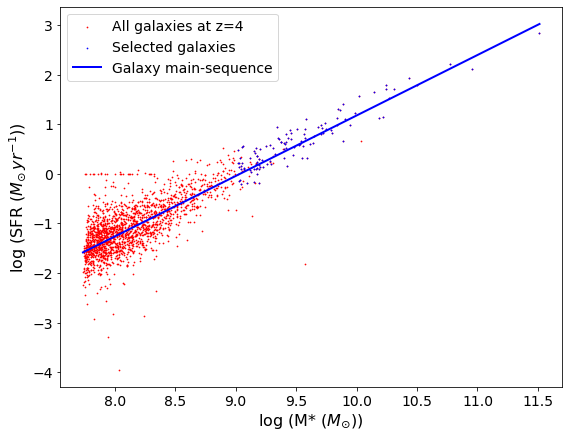

In [48]:
plt.figure(figsize=(9,7))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(np.log10(mstar),np.log10(sfr),s=0.5,color="red")
plt.scatter(np.log10(mod_mstar),np.log10(mod_sfr),s=0.5,color="blue")
plt.plot(np.log10(modified_mstar),np.log10(modified_ms_sfr),linewidth=2,color="blue")
plt.xlabel("log (M* ($M_{\odot}$))",fontsize=16)
plt.ylabel("log (SFR ($M_{\odot}\,yr^{-1}$))",fontsize=16)
plt.legend(["All galaxies at z=4","Selected galaxies","Galaxy main-sequence"],fontsize=14)
#plt.savefig("Main sequence selection redshift 4.jpg",dpi=200)
plt.show()

/scratch/local/53455563/ipykernel_30510/1143324626.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(mstar),np.log10(sfr),s=0.5,color="red")


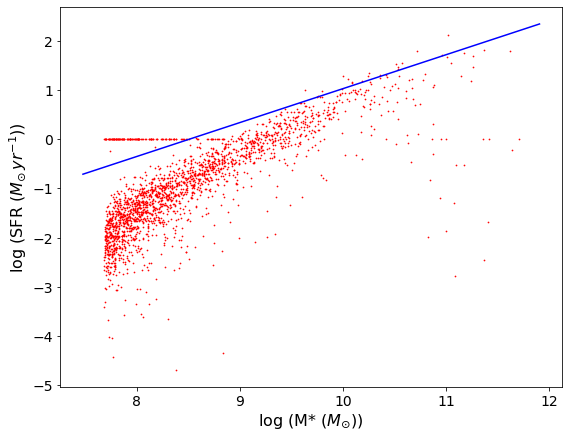

In [36]:
#Speagle MS

import caesar
import numpy as np
import matplotlib.pyplot as plt

obj = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0210_z1.037.hdf5")

mstar = [gal.masses["stellar"] for gal in obj.galaxies]
sfr = [gal.sfr for gal in obj.galaxies]

t = obj.simulation.time.to('Gyr').value    #age of the Universe at specified redshift in Gyr

plt.figure(figsize=(9,7))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(np.log10(mstar),np.log10(sfr),s=0.5,color="red")
left,right = plt.xlim()
mstar_MS = np.linspace(10**left,10**right,100)
sfr_MS = 10**((0.84-0.026*t)*np.log10(mstar_MS) - (6.51-0.11*t))
plt.xlabel("log (M* ($M_{\odot}$))",fontsize=16)
plt.ylabel("log (SFR ($M_{\odot}\,yr^{-1}$))",fontsize=16)
plt.plot(np.log10(mstar_MS),np.log10(sfr_MS),color="blue")
plt.scatter(np.log10(mod_mstar),np.log10(mod_sfr),s=0.5,color="blue")
#plt.legend(["All galaxies at z=1","Selected galaxies","Galaxy main-sequence"],fontsize=14)
plt.show()

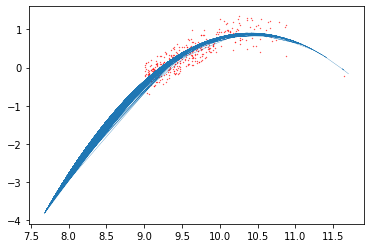

In [6]:
plt.scatter(np.log10(mod_mstar),np.log10(mod_sfr),s=0.1,color="red")
plt.plot(np.log10(mstar),np.log10(ms_sfr),linewidth=0.3)
plt.show()

In [ ]:
caesar_0115_z3.489.hdf5 ; caesar_0150_z2.262.hdf5 ; caesar_0210_z1.037.hdf5

In [2]:
obj_1 = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0210_z1.037.hdf5")

yt : [INFO     ] 2022-10-05 01:32:48,090 Opening /orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0210_z1.037.hdf5
yt : [INFO     ] 2022-10-05 01:32:48,796 Found 97686 halos
yt : [INFO     ] 2022-10-05 01:32:48,934 Found 2342 galaxies
yt : [INFO     ] 2022-10-05 01:32:49,048 Found 15812 clouds


In [3]:
obj_2 = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0150_z2.262.hdf5")

yt : [INFO     ] 2022-10-05 01:32:49,203 Opening /orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0150_z2.262.hdf5
yt : [INFO     ] 2022-10-05 01:32:49,427 Found 103182 halos
yt : [INFO     ] 2022-10-05 01:32:49,596 Found 2124 galaxies
yt : [INFO     ] 2022-10-05 01:32:49,750 Found 22735 clouds


In [4]:
obj_3 = caesar.load("/orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0115_z3.489.hdf5")

yt : [INFO     ] 2022-10-05 01:32:49,935 Opening /orange/narayanan/desika.narayanan/gizmo_runs/simba/m25n512/output/Groups/caesar_0115_z3.489.hdf5
yt : [INFO     ] 2022-10-05 01:32:50,176 Found 98071 halos
yt : [INFO     ] 2022-10-05 01:32:50,310 Found 1916 galaxies
yt : [INFO     ] 2022-10-05 01:32:50,462 Found 26523 clouds


In [13]:
gas_mass = [[gal.masses['gas'].in_units("Msun") for gal in obj.galaxies] for obj in [obj_1,obj_2,obj_3]]
stellar_mass = [[gal.masses['stellar'].in_units("Msun") for gal in obj.galaxies] for obj in [obj_1,obj_2,obj_3]]
SFR = [[gal.sfr.in_units("Msun/yr") for gal in obj.galaxies] for obj in [obj_1,obj_2,obj_3]]
sSFR = [np.array(SFR[i])/np.array(stellar_mass[i]) for i in [0,1,2]]
Zgas = [[gal.metallicities['mass_weighted'] for gal in obj.galaxies] for obj in [obj_1,obj_2,obj_3]]
gas_radius = [[gal.radii['gas_half_mass'].in_units("kpc") for gal in obj.galaxies] for obj in [obj_1,obj_2,obj_3]]
stellar_radius = [[gal.radii['stellar_half_mass'].in_units("kpc") for gal in obj.galaxies] for obj in [obj_1,obj_2,obj_3]]
total_radius = [[gal.radii['total_half_mass'] for gal in obj.galaxies] for obj in [obj_1,obj_2,obj_3]]

/scratch/local/48172582/ipykernel_32807/273068317.py:2: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(sSFR[0]),s=0.5,c=np.log10(np.array(Zgas[0])/0.0196),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/273068317.py:8: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(sSFR[1]),s=0.5,c=np.log10(np.array(Zgas[1])/0.0196),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/273068317.py:14: RuntimeWarning: divide by zero encountered in log10
  im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(sSFR[2]),s=0.5,c=np.log10(np.array(Zgas[2])/0.0196),cmap='viridis')


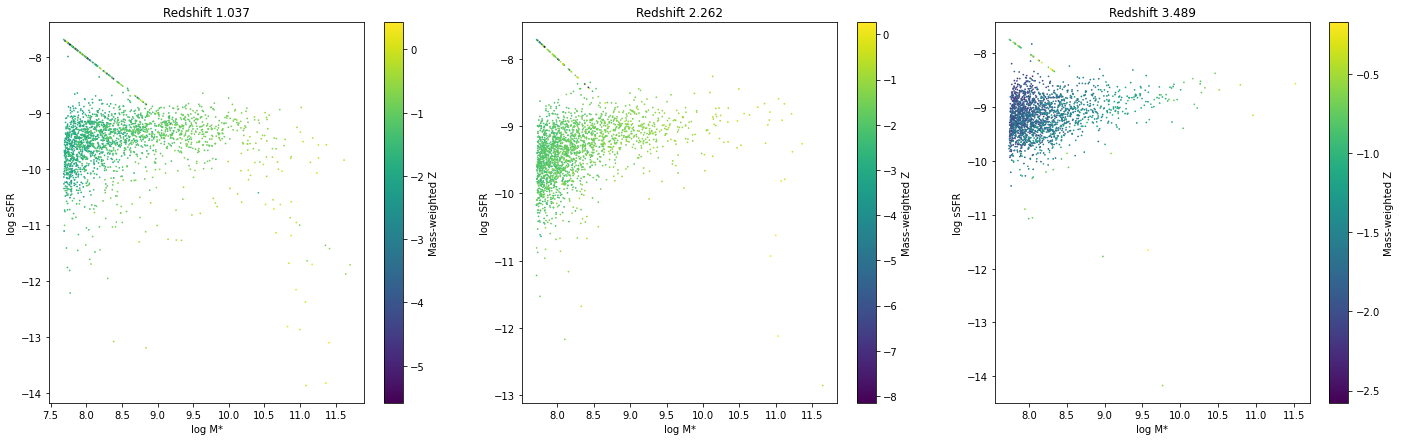

In [9]:
fig, ax = plt.subplots(1,3,figsize=(24,7))
im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(sSFR[0]),s=0.5,c=np.log10(np.array(Zgas[0])/0.0196),cmap='viridis')
ax[0].set_xlabel("log M*")
ax[0].set_ylabel("log sSFR")
ax[0].set_title("Redshift 1.037")
cbar0 = fig.colorbar(im0,ax=ax[0])
cbar0.set_label("Mass-weighted Z")
im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(sSFR[1]),s=0.5,c=np.log10(np.array(Zgas[1])/0.0196),cmap='viridis')
ax[1].set_xlabel("log M*")
ax[1].set_ylabel("log sSFR")
ax[1].set_title("Redshift 2.262")
cbar1 = fig.colorbar(im1,ax=ax[1])
cbar1.set_label("Mass-weighted Z")
im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(sSFR[2]),s=0.5,c=np.log10(np.array(Zgas[2])/0.0196),cmap='viridis')
ax[2].set_xlabel("log M*")
ax[2].set_ylabel("log sSFR")
ax[2].set_title("Redshift 3.489")
cbar2 = fig.colorbar(im2,ax=ax[2])
cbar2.set_label("Mass-weighted Z")
#plt.show()
plt.savefig("test.jpg",dpi=300)

/scratch/local/48172582/ipykernel_32807/2232853431.py:2: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(SFR[0]),s=0.5,c=np.log10(np.array(Zgas[0])/0.0196),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/2232853431.py:8: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(SFR[1]),s=0.5,c=np.log10(np.array(Zgas[1])/0.0196),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/2232853431.py:14: RuntimeWarning: divide by zero encountered in log10
  im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(SFR[2]),s=0.5,c=np.log10(np.array(Zgas[2])/0.0196),cmap='viridis')


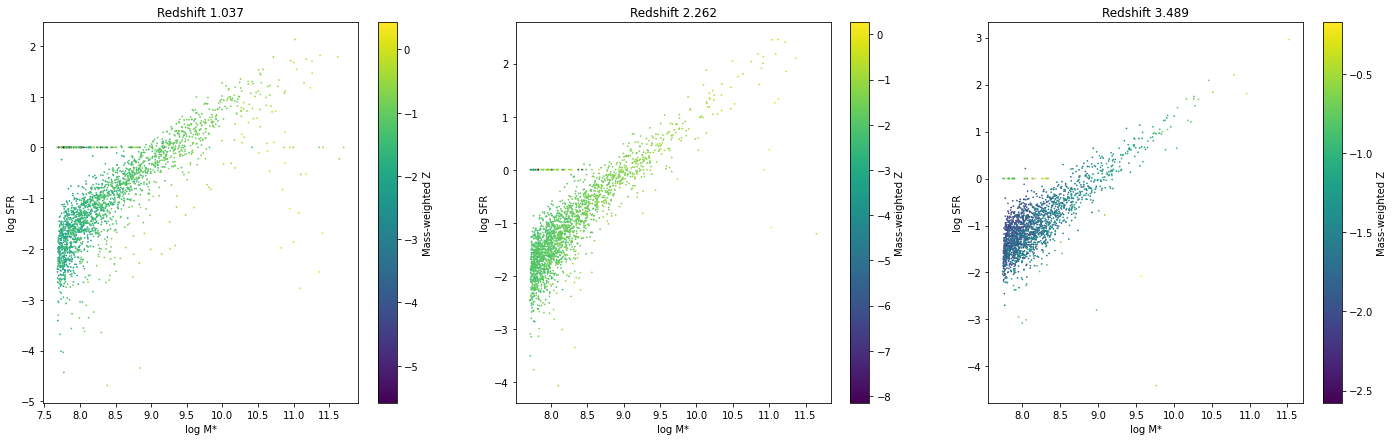

In [10]:
fig, ax = plt.subplots(1,3,figsize=(24,7))
im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(SFR[0]),s=0.5,c=np.log10(np.array(Zgas[0])/0.0196),cmap='viridis')
ax[0].set_xlabel("log M*")
ax[0].set_ylabel("log SFR")
ax[0].set_title("Redshift 1.037")
cbar0 = fig.colorbar(im0,ax=ax[0])
cbar0.set_label("Mass-weighted Z")
im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(SFR[1]),s=0.5,c=np.log10(np.array(Zgas[1])/0.0196),cmap='viridis')
ax[1].set_xlabel("log M*")
ax[1].set_ylabel("log SFR")
ax[1].set_title("Redshift 2.262")
cbar1 = fig.colorbar(im1,ax=ax[1])
cbar1.set_label("Mass-weighted Z")
im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(SFR[2]),s=0.5,c=np.log10(np.array(Zgas[2])/0.0196),cmap='viridis')
ax[2].set_xlabel("log M*")
ax[2].set_ylabel("log SFR")
ax[2].set_title("Redshift 3.489")
cbar2 = fig.colorbar(im2,ax=ax[2])
cbar2.set_label("Mass-weighted Z")
#plt.show()
plt.savefig("SFR vs Mstar for z123.jpg",dpi=300)

/scratch/local/48172582/ipykernel_32807/3487292130.py:2: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(np.array(Zgas[0])/0.0196),s=0.5,c=np.log10(sSFR[0]),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/3487292130.py:8: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(np.array(Zgas[1])/0.0196),s=0.5,c=np.log10(sSFR[1]),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/3487292130.py:14: RuntimeWarning: divide by zero encountered in log10
  im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(np.array(Zgas[2])/0.0196),s=0.5,c=np.log10(sSFR[2]),cmap='viridis')


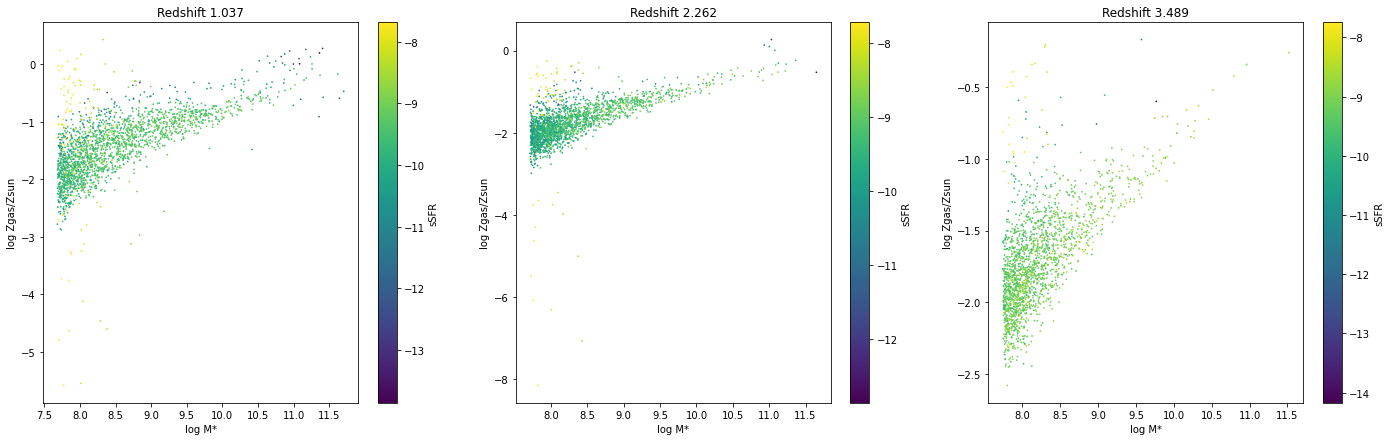

In [11]:
fig, ax = plt.subplots(1,3,figsize=(24,7))
im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(np.array(Zgas[0])/0.0196),s=0.5,c=np.log10(sSFR[0]),cmap='viridis')
ax[0].set_xlabel("log M*")
ax[0].set_ylabel("log Zgas/Zsun")
ax[0].set_title("Redshift 1.037")
cbar0 = fig.colorbar(im0,ax=ax[0])
cbar0.set_label("sSFR")
im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(np.array(Zgas[1])/0.0196),s=0.5,c=np.log10(sSFR[1]),cmap='viridis')
ax[1].set_xlabel("log M*")
ax[1].set_ylabel("log Zgas/Zsun")
ax[1].set_title("Redshift 2.262")
cbar1 = fig.colorbar(im1,ax=ax[1])
cbar1.set_label("sSFR")
im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(np.array(Zgas[2])/0.0196),s=0.5,c=np.log10(sSFR[2]),cmap='viridis')
ax[2].set_xlabel("log M*")
ax[2].set_ylabel("log Zgas/Zsun")
ax[2].set_title("Redshift 3.489")
cbar2 = fig.colorbar(im2,ax=ax[2])
cbar2.set_label("sSFR")
#plt.show()
plt.savefig("Normalized Zgas vs Mstar for z123.jpg",dpi=300)

/scratch/local/48172582/ipykernel_32807/280357475.py:2: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(gas_mass[0]),s=0.5,c=np.log10(np.array(Zgas[0])/0.0196),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/280357475.py:8: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(gas_mass[1]),s=0.5,c=np.log10(np.array(Zgas[1])/0.0196),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/280357475.py:14: RuntimeWarning: divide by zero encountered in log10
  im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(gas_mass[2]),s=0.5,c=np.log10(np.array(Zgas[2])/0.0196),cmap='viridis')


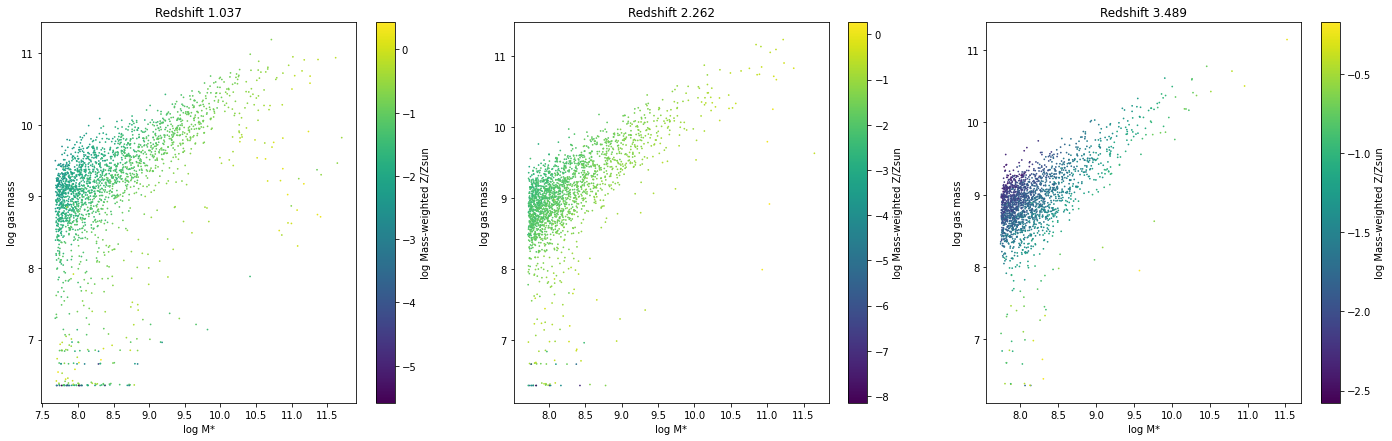

In [12]:
fig, ax = plt.subplots(1,3,figsize=(24,7))
im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(gas_mass[0]),s=0.5,c=np.log10(np.array(Zgas[0])/0.0196),cmap='viridis')
ax[0].set_xlabel("log M*")
ax[0].set_ylabel("log gas mass")
ax[0].set_title("Redshift 1.037")
cbar0 = fig.colorbar(im0,ax=ax[0])
cbar0.set_label("log Mass-weighted Z/Zsun")
im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(gas_mass[1]),s=0.5,c=np.log10(np.array(Zgas[1])/0.0196),cmap='viridis')
ax[1].set_xlabel("log M*")
ax[1].set_ylabel("log gas mass")
ax[1].set_title("Redshift 2.262")
cbar1 = fig.colorbar(im1,ax=ax[1])
cbar1.set_label("log Mass-weighted Z/Zsun")
im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(gas_mass[2]),s=0.5,c=np.log10(np.array(Zgas[2])/0.0196),cmap='viridis')
ax[2].set_xlabel("log M*")
ax[2].set_ylabel("log gas mass")
ax[2].set_title("Redshift 3.489")
cbar2 = fig.colorbar(im2,ax=ax[2])
cbar2.set_label("log Mass-weighted Z/Zsun")
#plt.show()
plt.savefig("gas mass vs Mstar for z123.jpg",dpi=300)

/scratch/local/48172582/ipykernel_32807/2326853994.py:2: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(gas_mass[0]),s=0.5,c=np.log10(sSFR[0]),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/2326853994.py:8: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(gas_mass[1]),s=0.5,c=np.log10(sSFR[1]),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/2326853994.py:14: RuntimeWarning: divide by zero encountered in log10
  im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(gas_mass[2]),s=0.5,c=np.log10(sSFR[2]),cmap='viridis')


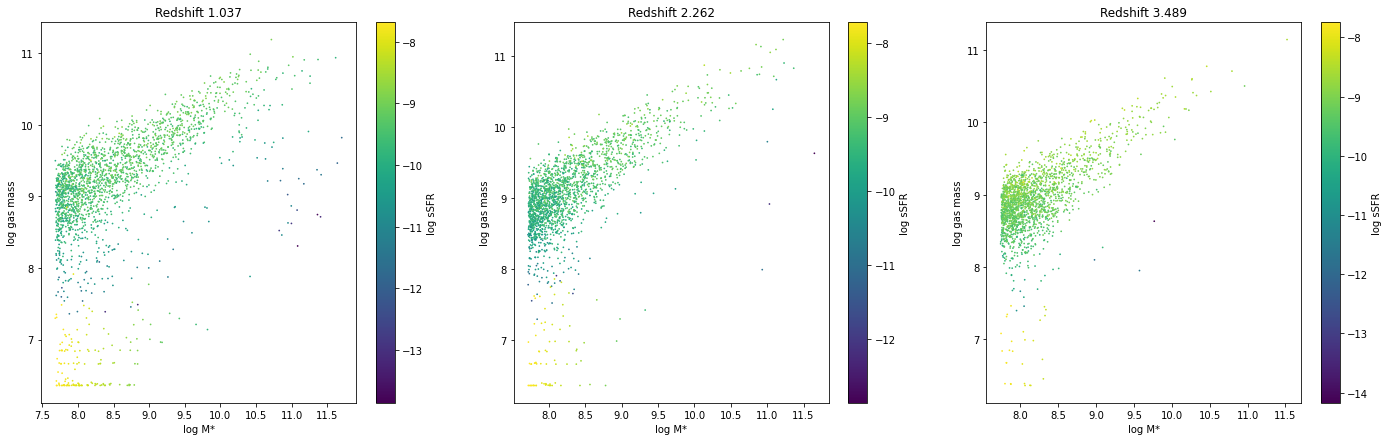

In [13]:
fig, ax = plt.subplots(1,3,figsize=(24,7))
im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(gas_mass[0]),s=0.5,c=np.log10(sSFR[0]),cmap='viridis')
ax[0].set_xlabel("log M*")
ax[0].set_ylabel("log gas mass")
ax[0].set_title("Redshift 1.037")
cbar0 = fig.colorbar(im0,ax=ax[0])
cbar0.set_label("log sSFR")
im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(gas_mass[1]),s=0.5,c=np.log10(sSFR[1]),cmap='viridis')
ax[1].set_xlabel("log M*")
ax[1].set_ylabel("log gas mass")
ax[1].set_title("Redshift 2.262")
cbar1 = fig.colorbar(im1,ax=ax[1])
cbar1.set_label("log sSFR")
im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(gas_mass[2]),s=0.5,c=np.log10(sSFR[2]),cmap='viridis')
ax[2].set_xlabel("log M*")
ax[2].set_ylabel("log gas mass")
ax[2].set_title("Redshift 3.489")
cbar2 = fig.colorbar(im2,ax=ax[2])
cbar2.set_label("log sSFR")
#plt.show()
plt.savefig("gas mass vs Mstar wt by sSFR for z123.jpg",dpi=300)

/scratch/local/48172582/ipykernel_32807/2344005186.py:2: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].scatter(np.log10(stellar_mass[0]),(np.array(gas_radius[0])/np.array(total_radius[0])),s=0.5,c=np.log10(np.array(Zgas[0])/0.0196),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/2344005186.py:8: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].scatter(np.log10(stellar_mass[1]),(np.array(gas_radius[1])/np.array(total_radius[1])),s=0.5,c=np.log10(np.array(Zgas[1])/0.0196),cmap='viridis')
/scratch/local/48172582/ipykernel_32807/2344005186.py:14: RuntimeWarning: divide by zero encountered in log10
  im2 = ax[2].scatter(np.log10(stellar_mass[2]),(np.array(gas_radius[2])/np.array(total_radius[2])),s=0.5,c=np.log10(np.array(Zgas[2])/0.0196),cmap='viridis')


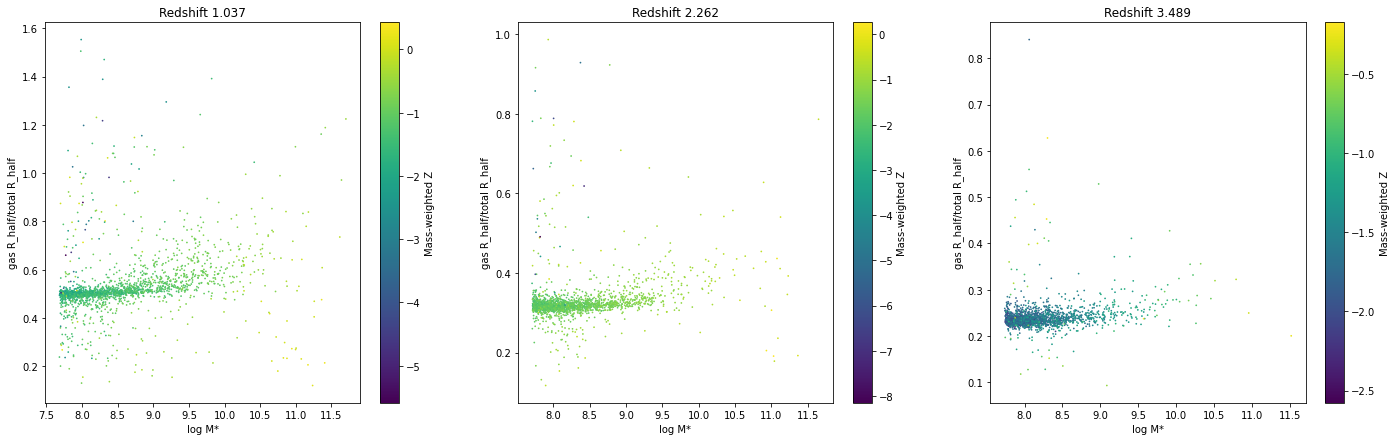

In [14]:
fig, ax = plt.subplots(1,3,figsize=(24,7))
im0 = ax[0].scatter(np.log10(stellar_mass[0]),(np.array(gas_radius[0])/np.array(total_radius[0])),s=0.5,c=np.log10(np.array(Zgas[0])/0.0196),cmap='viridis')
ax[0].set_xlabel("log M*")
ax[0].set_ylabel("gas R_half/total R_half")
ax[0].set_title("Redshift 1.037")
cbar0 = fig.colorbar(im0,ax=ax[0])
cbar0.set_label("Mass-weighted Z")
im1 = ax[1].scatter(np.log10(stellar_mass[1]),(np.array(gas_radius[1])/np.array(total_radius[1])),s=0.5,c=np.log10(np.array(Zgas[1])/0.0196),cmap='viridis')
ax[1].set_xlabel("log M*")
ax[1].set_ylabel("gas R_half/total R_half")
ax[1].set_title("Redshift 2.262")
cbar1 = fig.colorbar(im1,ax=ax[1])
cbar1.set_label("Mass-weighted Z")
im2 = ax[2].scatter(np.log10(stellar_mass[2]),(np.array(gas_radius[2])/np.array(total_radius[2])),s=0.5,c=np.log10(np.array(Zgas[2])/0.0196),cmap='viridis')
ax[2].set_xlabel("log M*")
ax[2].set_ylabel("gas R_half/total R_half")
ax[2].set_title("Redshift 3.489")
cbar2 = fig.colorbar(im2,ax=ax[2])
cbar2.set_label("Mass-weighted Z")
#plt.show()
plt.savefig("gas half-mass radius norm to total half-mass radius vs Mstar for z123.jpg",dpi=300)

/scratch/local/48397464/ipykernel_8710/877447576.py:2: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].scatter(np.log10(stellar_mass[0]),(np.array(gas_radius[0])/np.array(total_radius[0])),s=0.5,c=np.log10(np.array(SFR[0])),cmap='viridis')
/scratch/local/48397464/ipykernel_8710/877447576.py:8: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].scatter(np.log10(stellar_mass[1]),(np.array(gas_radius[1])/np.array(total_radius[1])),s=0.5,c=np.log10(np.array(SFR[1])),cmap='viridis')
/scratch/local/48397464/ipykernel_8710/877447576.py:14: RuntimeWarning: divide by zero encountered in log10
  im2 = ax[2].scatter(np.log10(stellar_mass[2]),(np.array(gas_radius[2])/np.array(total_radius[2])),s=0.5,c=np.log10(np.array(SFR[2])),cmap='viridis')


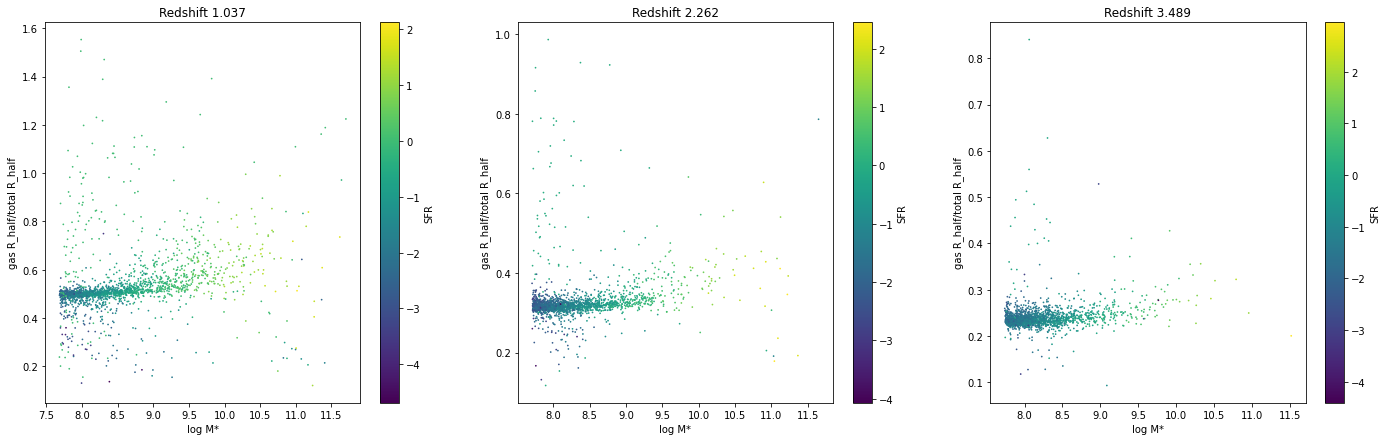

In [7]:
fig, ax = plt.subplots(1,3,figsize=(24,7))
im0 = ax[0].scatter(np.log10(stellar_mass[0]),(np.array(gas_radius[0])/np.array(total_radius[0])),s=0.5,c=np.log10(np.array(SFR[0])),cmap='viridis')
ax[0].set_xlabel("log M*")
ax[0].set_ylabel("gas R_half/total R_half")
ax[0].set_title("Redshift 1.037")
cbar0 = fig.colorbar(im0,ax=ax[0])
cbar0.set_label("SFR")
im1 = ax[1].scatter(np.log10(stellar_mass[1]),(np.array(gas_radius[1])/np.array(total_radius[1])),s=0.5,c=np.log10(np.array(SFR[1])),cmap='viridis')
ax[1].set_xlabel("log M*")
ax[1].set_ylabel("gas R_half/total R_half")
ax[1].set_title("Redshift 2.262")
cbar1 = fig.colorbar(im1,ax=ax[1])
cbar1.set_label("SFR")
im2 = ax[2].scatter(np.log10(stellar_mass[2]),(np.array(gas_radius[2])/np.array(total_radius[2])),s=0.5,c=np.log10(np.array(SFR[2])),cmap='viridis')
ax[2].set_xlabel("log M*")
ax[2].set_ylabel("gas R_half/total R_half")
ax[2].set_title("Redshift 3.489")
cbar2 = fig.colorbar(im2,ax=ax[2])
cbar2.set_label("SFR")
plt.show()
#plt.savefig("gas half-mass radius norm to total half-mass radius vs Mstar for z123.jpg",dpi=300)

/scratch/local/48397464/ipykernel_8710/3337875347.py:2: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].scatter(np.log10(stellar_mass[0]),(np.array(gas_radius[0])/np.array(stellar_radius[0])),s=0.5,c=np.log10(np.array(SFR[0])),cmap='viridis')
/scratch/local/48397464/ipykernel_8710/3337875347.py:8: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].scatter(np.log10(stellar_mass[1]),(np.array(gas_radius[1])/np.array(stellar_radius[1])),s=0.5,c=np.log10(np.array(SFR[1])),cmap='viridis')
/scratch/local/48397464/ipykernel_8710/3337875347.py:14: RuntimeWarning: divide by zero encountered in log10
  im2 = ax[2].scatter(np.log10(stellar_mass[2]),(np.array(gas_radius[2])/np.array(stellar_radius[2])),s=0.5,c=np.log10(np.array(SFR[2])),cmap='viridis')


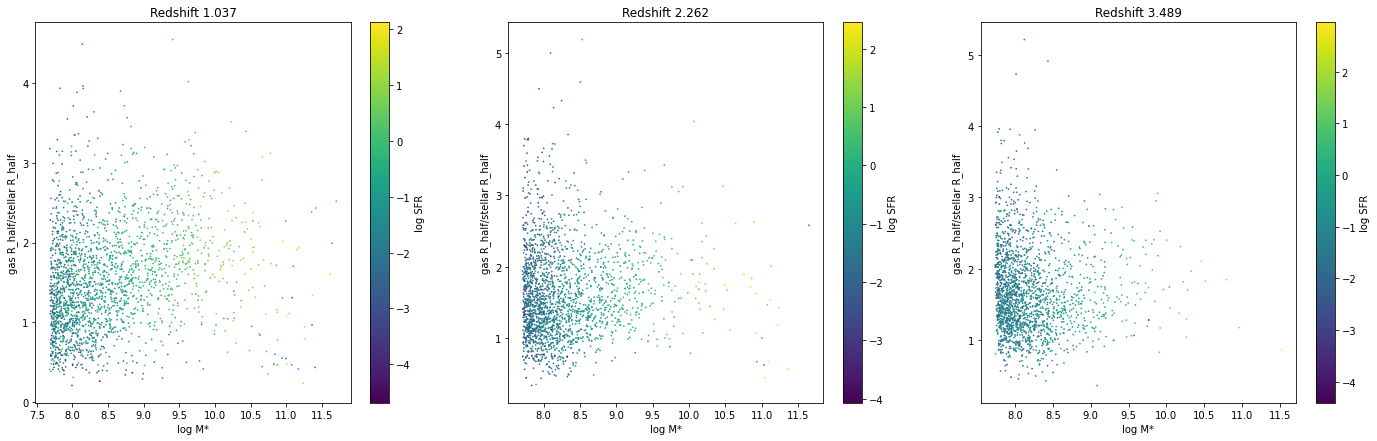

In [14]:
fig, ax = plt.subplots(1,3,figsize=(24,7))
im0 = ax[0].scatter(np.log10(stellar_mass[0]),(np.array(gas_radius[0])/np.array(stellar_radius[0])),s=0.5,c=np.log10(np.array(SFR[0])),cmap='viridis')
ax[0].set_xlabel("log M*")
ax[0].set_ylabel("gas R_half/stellar R_half")
ax[0].set_title("Redshift 1.037")
cbar0 = fig.colorbar(im0,ax=ax[0])
cbar0.set_label("log SFR")
im1 = ax[1].scatter(np.log10(stellar_mass[1]),(np.array(gas_radius[1])/np.array(stellar_radius[1])),s=0.5,c=np.log10(np.array(SFR[1])),cmap='viridis')
ax[1].set_xlabel("log M*")
ax[1].set_ylabel("gas R_half/stellar R_half")
ax[1].set_title("Redshift 2.262")
cbar1 = fig.colorbar(im1,ax=ax[1])
cbar1.set_label("log SFR")
im2 = ax[2].scatter(np.log10(stellar_mass[2]),(np.array(gas_radius[2])/np.array(stellar_radius[2])),s=0.5,c=np.log10(np.array(SFR[2])),cmap='viridis')
ax[2].set_xlabel("log M*")
ax[2].set_ylabel("gas R_half/stellar R_half")
ax[2].set_title("Redshift 3.489")
cbar2 = fig.colorbar(im2,ax=ax[2])
cbar2.set_label("log SFR")
plt.show()
#plt.savefig("gas half-mass radius norm to total half-mass radius vs Mstar for z123.jpg",dpi=300)

/scratch/local/48397464/ipykernel_8710/3136856164.py:2: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(np.array(gas_radius[0])),s=0.5,c=np.log10(np.array(SFR[0])),cmap='viridis')
/scratch/local/48397464/ipykernel_8710/3136856164.py:8: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(np.array(gas_radius[1])),s=0.5,c=np.log10(np.array(SFR[1])),cmap='viridis')
/scratch/local/48397464/ipykernel_8710/3136856164.py:14: RuntimeWarning: divide by zero encountered in log10
  im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(np.array(gas_radius[2])),s=0.5,c=np.log10(np.array(SFR[2])),cmap='viridis')


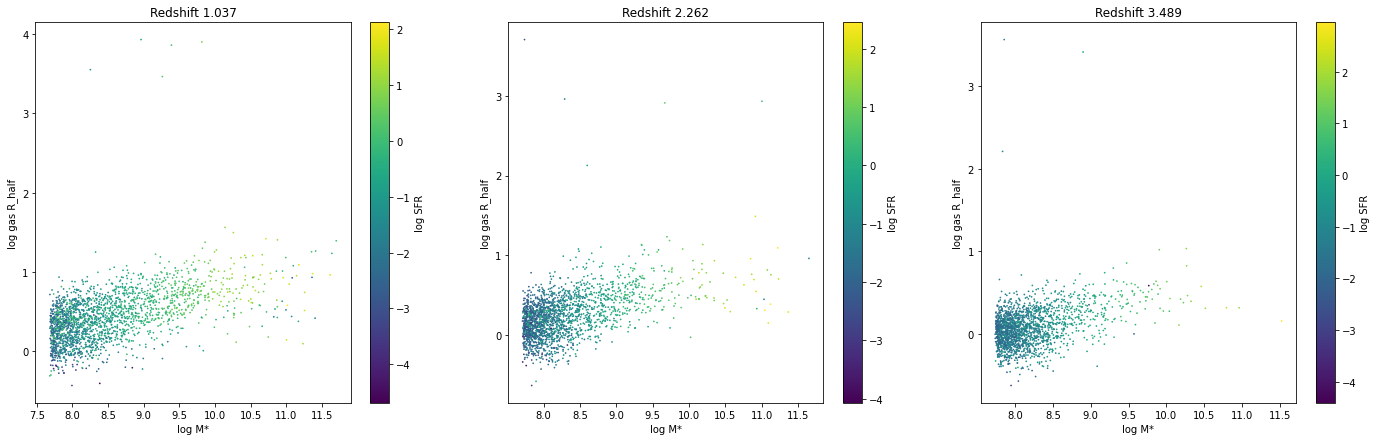

In [17]:
fig, ax = plt.subplots(1,3,figsize=(24,7))
im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(np.array(gas_radius[0])),s=0.5,c=np.log10(np.array(SFR[0])),cmap='viridis')
ax[0].set_xlabel("log M*")
ax[0].set_ylabel("log gas R_half")
ax[0].set_title("Redshift 1.037")
cbar0 = fig.colorbar(im0,ax=ax[0])
cbar0.set_label("log SFR")
im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(np.array(gas_radius[1])),s=0.5,c=np.log10(np.array(SFR[1])),cmap='viridis')
ax[1].set_xlabel("log M*")
ax[1].set_ylabel("log gas R_half")
ax[1].set_title("Redshift 2.262")
cbar1 = fig.colorbar(im1,ax=ax[1])
cbar1.set_label("log SFR")
im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(np.array(gas_radius[2])),s=0.5,c=np.log10(np.array(SFR[2])),cmap='viridis')
ax[2].set_xlabel("log M*")
ax[2].set_ylabel("log gas R_half")
ax[2].set_title("Redshift 3.489")
cbar2 = fig.colorbar(im2,ax=ax[2])
cbar2.set_label("log SFR")
plt.show()
#plt.savefig("gas half-mass radius norm to total half-mass radius vs Mstar for z123.jpg",dpi=300)

/scratch/local/48397464/ipykernel_8710/3880605311.py:2: RuntimeWarning: invalid value encountered in true_divide
  im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(np.array(gas_mass[0])/np.array(SFR[0])),s=0.5,c=np.log10(np.array(SFR[0])),cmap='viridis')
/scratch/local/48397464/ipykernel_8710/3880605311.py:2: RuntimeWarning: divide by zero encountered in log10
  im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(np.array(gas_mass[0])/np.array(SFR[0])),s=0.5,c=np.log10(np.array(SFR[0])),cmap='viridis')
/scratch/local/48397464/ipykernel_8710/3880605311.py:8: RuntimeWarning: invalid value encountered in true_divide
  im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(np.array(gas_mass[1])/np.array(SFR[1])),s=0.5,c=np.log10(np.array(SFR[1])),cmap='viridis')
/scratch/local/48397464/ipykernel_8710/3880605311.py:8: RuntimeWarning: divide by zero encountered in log10
  im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(np.array(gas_mass[1])/np.array(SFR[1])),s=0.5,c=np.log10(

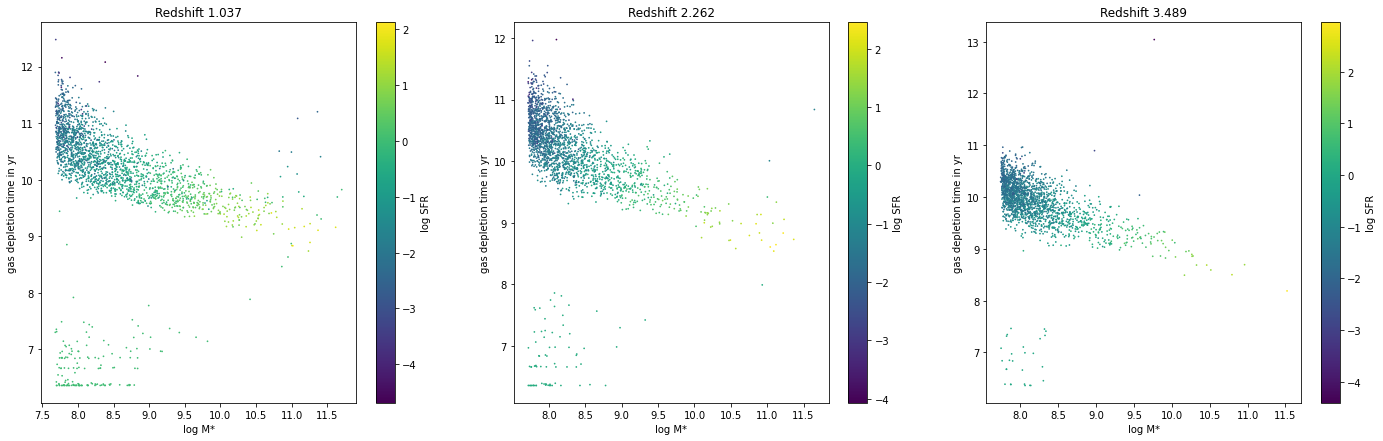

In [23]:
fig, ax = plt.subplots(1,3,figsize=(24,7))
im0 = ax[0].scatter(np.log10(stellar_mass[0]),np.log10(np.array(gas_mass[0])/np.array(SFR[0])),s=0.5,c=np.log10(np.array(SFR[0])),cmap='viridis')
ax[0].set_xlabel("log M*")
ax[0].set_ylabel("gas depletion time in yr")
ax[0].set_title("Redshift 1.037")
cbar0 = fig.colorbar(im0,ax=ax[0])
cbar0.set_label("log SFR")
im1 = ax[1].scatter(np.log10(stellar_mass[1]),np.log10(np.array(gas_mass[1])/np.array(SFR[1])),s=0.5,c=np.log10(np.array(SFR[1])),cmap='viridis')
ax[1].set_xlabel("log M*")
ax[1].set_ylabel("gas depletion time in yr")
ax[1].set_title("Redshift 2.262")
cbar1 = fig.colorbar(im1,ax=ax[1])
cbar1.set_label("log SFR")
im2 = ax[2].scatter(np.log10(stellar_mass[2]),np.log10(np.array(gas_mass[2])/np.array(SFR[2])),s=0.5,c=np.log10(np.array(SFR[2])),cmap='viridis')
ax[2].set_xlabel("log M*")
ax[2].set_ylabel("gas depletion time in yr")
ax[2].set_title("Redshift 3.489")
cbar2 = fig.colorbar(im2,ax=ax[2])
cbar2.set_label("log SFR")
plt.show()
#plt.savefig("gas half-mass radius norm to total half-mass radius vs Mstar for z123.jpg",dpi=300)